In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, multilabel_confusion_matrix, ConfusionMatrixDisplay

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Link to Assignment:
https://docs.google.com/document/d/1savsuz2g5zOVs9igef1dF5xuueomoS8Eow8Qr9rMifg/edit

# Task 1
Load the dataset into a Python notebook and test the performance of the following models:
a k-Nearest Neighbour
b Decision Tree
c Logistic Regression
d Random Forest


In [ ]:
df = pd.read_csv('Dry_Bean_Dataset.csv')
df

In [3]:
X = df.drop(columns='Class')
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_test = StandardScaler().fit_transform(X_train), StandardScaler().fit_transform(X_test)

In [4]:
def print_metrics(y_test, y_pred):
    round_digits = 4
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average=None)
    
    print("Accuracy:", round(accuracy, round_digits))
    print("Precision:", round(precision, round_digits))
    print("Recall:", round(recall, round_digits))
    
    print("\nF1:", np.round(f1, decimals=round_digits))
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    recall_sira = mcm[6][1][1] / (mcm[6][1][0] + mcm[6][1][1])
    print("Recall Sira:", round(recall_sira, round_digits))

    print("\nConfusion Matrix:")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='RdPu', xticks_rotation=45.0)

### a. k-Nearest Neighbour

In [ ]:
kNN = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='euclidean')
kNN.fit(X_train, y_train)
y_pred = kNN.predict(X_test)

print_metrics(y_test, y_pred)

### b. Decision Tree

In [ ]:
dT = DecisionTreeClassifier(criterion='log_loss', min_impurity_decrease=0.001)
dT.fit(X_train, y_train)
y_pred = dT.predict(X_test)

print_metrics(y_test, y_pred)

### c. Logistic regression

Accuracy: 0.923
Precision: 0.9237
Recall: 0.923

F1: [0.9172 1.     0.9397 0.9109 0.9649 0.9461 0.8677]
Recall Sira: 0.8827

Confusion Matrix:


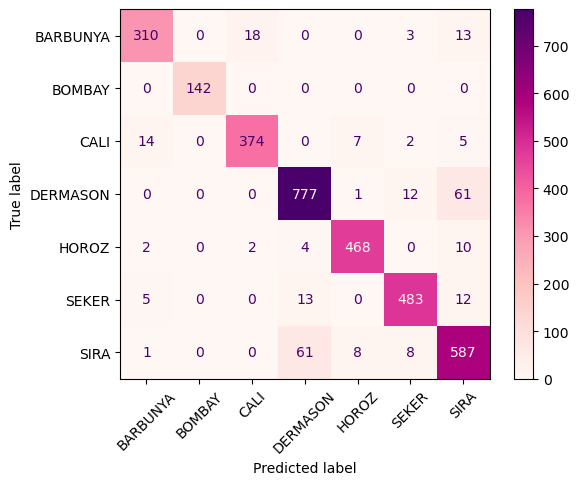

In [7]:
lR = LogisticRegression(max_iter=30000)
lR.fit(X_train, y_train)
y_pred = lR.predict(X_test)

print_metrics(y_test, y_pred)

### d. Randomforest

Accuracy: 0.9177
Precision: 0.9183
Recall: 0.9177

F1: [0.9145 1.     0.9333 0.9032 0.9598 0.9399 0.8632]
Recall Sira: 0.8541

Confusion Matrix:


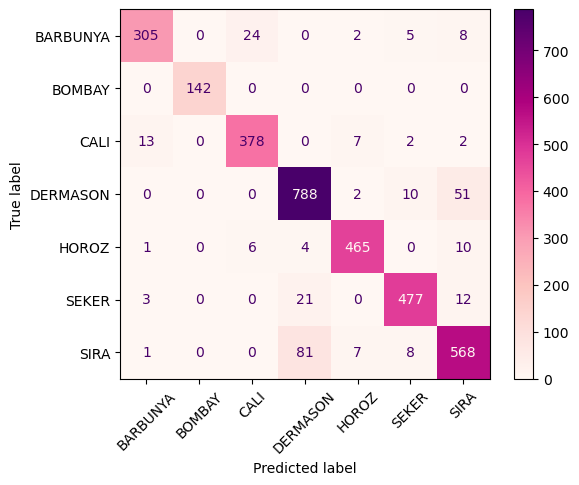

In [8]:
rFC = RandomForestClassifier(n_estimators=250, criterion='log_loss')
rFC.fit(X_train, y_train)
y_pred = rFC.predict(X_test)

print_metrics(y_test, y_pred)

### Discussion

All 4 ML algorithms have very similar accuracy, precision and recall scores with values between 91 and 93%. In fact, each of the three metrics are always extremely close to each other (average delta is <1 percentage point).
Furthermore, all 4 algorithms achieve perfect classification for the class 'Bombay'. 

In terms of execution time, kNN, DT and logistic regression are also similar with 150-300ms. Only the RandomForestClassifier needs significantly more time (6s). This is due to the fact that a Random Forest is an ensemble of many (here n=250) decision trees, whereas the others are single algorithms.

From the confusion matrix, it can be seen that most of the classification errors occur between the classes 'Dermason' and 'Sira' (over a hundred missclassifications per algorithm). This is crucial for the next task, as this problem will be essential to solve.

# Task 2
Imagine that one of the bean types (‘Sira’) is moderately poisonous. How should you ‘nudge’ the performance of a classifier to address this? What evaluation metric is appropriate to capture this? Starting with the research resources linked below, identify a method to address this issue; test this method on the dataset. You don’t need to get perfect accuracy on the ‘Sira’ classification, the objective is to improve performance on the ‘Sira’ class without too much impact on the other classes. Discuss your findings in markdown. 


In [9]:
class_dist = df['Class'].value_counts()
class_dist

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: count, dtype: int64

Sira is already the second largest class in the dataset in terms of the number of samples, so under- or over-sampling, although feasible, is not strictly necessary. 
Instead, the weight of the Sira class is increased by a factor of 10.

In [10]:
class_weights = {class_label: 1 for class_label, num_samples in class_dist.items()}
class_weights['SIRA'] = 10
class_weights

{'DERMASON': 1,
 'SIRA': 10,
 'SEKER': 1,
 'HOROZ': 1,
 'CALI': 1,
 'BARBUNYA': 1,
 'BOMBAY': 1}

Accuracy: 0.8922
Precision: 0.9155
Recall: 0.8922

F1: [0.9169 1.     0.9355 0.8532 0.9532 0.9463 0.8094]
Recall Sira: 0.9805

Confusion Matrix:


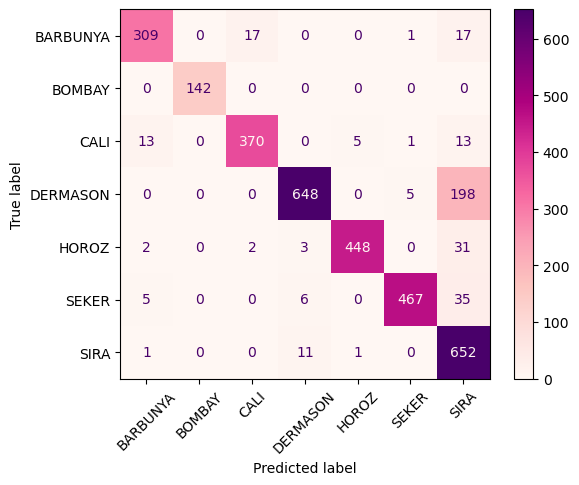

In [11]:
lR = LogisticRegression(max_iter=30000, class_weight=class_weights)
lR.fit(X_train, y_train)
y_pred = lR.predict(X_test)

print_metrics(y_test, y_pred)

By increasing the weight of the 'Sira' class by a factor of 10 and leaving the weights of the other classes unchanged, the number of false negatives for the 'Sira' class was drastically reduced, while the number of true positives was increased. This can be seen in the confusion matrix (only 13 FN, compared to an average of 70 FN in Task 1) and the resulting high recall of 98%.

As the 'Sira' bean is poisonous, it is crucial to reduce the number of FN (type II errors) as these can pose a risk to human health. The trade-off is that more samples from other classes (especially 'Dermason') are misclassified as 'Sira', leading to a higher number of false positives (Type I errors). However, as Type I errors are less costly in this example, the trade-off is likely to be worthwhile. 

Furthermore, the overall accuracy, precision and recall scores are only slightly affected, further supporting the rationale for this trade-off.